## My Objective

My goal is to solve the prediction task defined by the competition using the provided synthetic training and test data. Most likely, the target variable is whether a client subscribes to a term deposit (y = yes/no).

## What I Need to Clarify

  * I need to confirm the exact target variable — probably subscription outcome.

  * I should check the competition rules to understand the evaluation metric (AUC, accuracy, log loss, etc.).

## Understanding the Dataset

I’ve been given:

  * A synthetic training set (features + labels).

  * A synthetic test set (features only, no labels).

* Optionally, I can refer to the original Bank Marketing dataset for additional context or data augmentation.

## What I Plan to Do

  * Train models on the synthetic training dataset.

  * Use cross-validation to evaluate performance and avoid overfitting — especially important due to the distribution shift between training and test data.

* Optionally, I’ll try augmenting the training data with the original dataset to see if that helps with generalization.

## Key Challenge

There's a distribution shift between training and test data. The organizers made the synthetic test data close — but not identical — to the training distribution. I need to build a model that can handle this kind of shift and still generalize well.

## My Next Steps

1. Exploratory Data Analysis (EDA)

  * Understand the data distributions and compare them with the original dataset if needed.

2. Feature Engineering

  * Encode categorical variables.

  * Scale numeric features if necessary.

3. Modeling

  * Start with baseline models like Logistic Regression, XGBoost, LightGBM, and simple Neural Networks.

  * Use cross-validation for model selection and hyperparameter tuning.

4. Submission

  * Make predictions on the test set.

  * Submit the final predictions as per competition requirements.

## Critical Columns (Usually important for most analyses):

* `age` - Demographic information, often crucial for segmentation

* `balance` - Financial information, very important for financial analysis

* `duration` - Call duration (if this is call center data), often strongly correlated with outcomes

* `y` - This appears to be your target variable (likely binary outcome)

## Potentially Important Columns (Depends on context):

* `job` - Occupation/employment type

* `education` - Education level

* `housing` - Housing loan status

* `loan` - Personal loan status

* `marital` - Marital status

* `campaign` - Number of contacts during this campaign

* `pdays` - Days since last contact

* `previous` - Number of contacts before this campaign

* `poutcome` - Outcome of previous marketing campaign

## Columns to Consider Dropping (Depending on analysis):

* `default` - Often has very imbalanced data (mostly "no")

* `contact` - Contact communication type

* `day` - Day of month

* `month` - Last contact month

In [1]:
import sys
print(sys.executable)

c:\Users\himu23\AppData\Local\Programs\Python\Python312\python.exe


In [12]:
# Imports
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

# Classifiers
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

df_train = df_train.drop("id", axis =1 )
df_test = df_test.drop("id", axis =1)


In [4]:
df_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


## Data Visualizations

### 1. Correlation Heatmap (for Numerical Features)

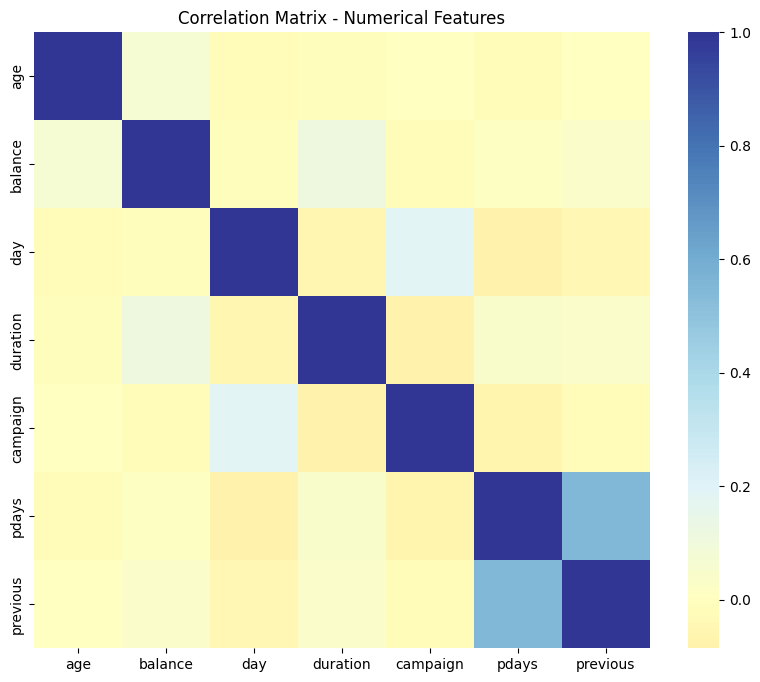

In [5]:
numerical_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays','previous']

corr_matrix = df_test[numerical_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap='RdYlBu', center=0, square=True)
plt.title("Correlation Matrix - Numerical Features")
plt.show()

### 2. Pairplot with Target Variables

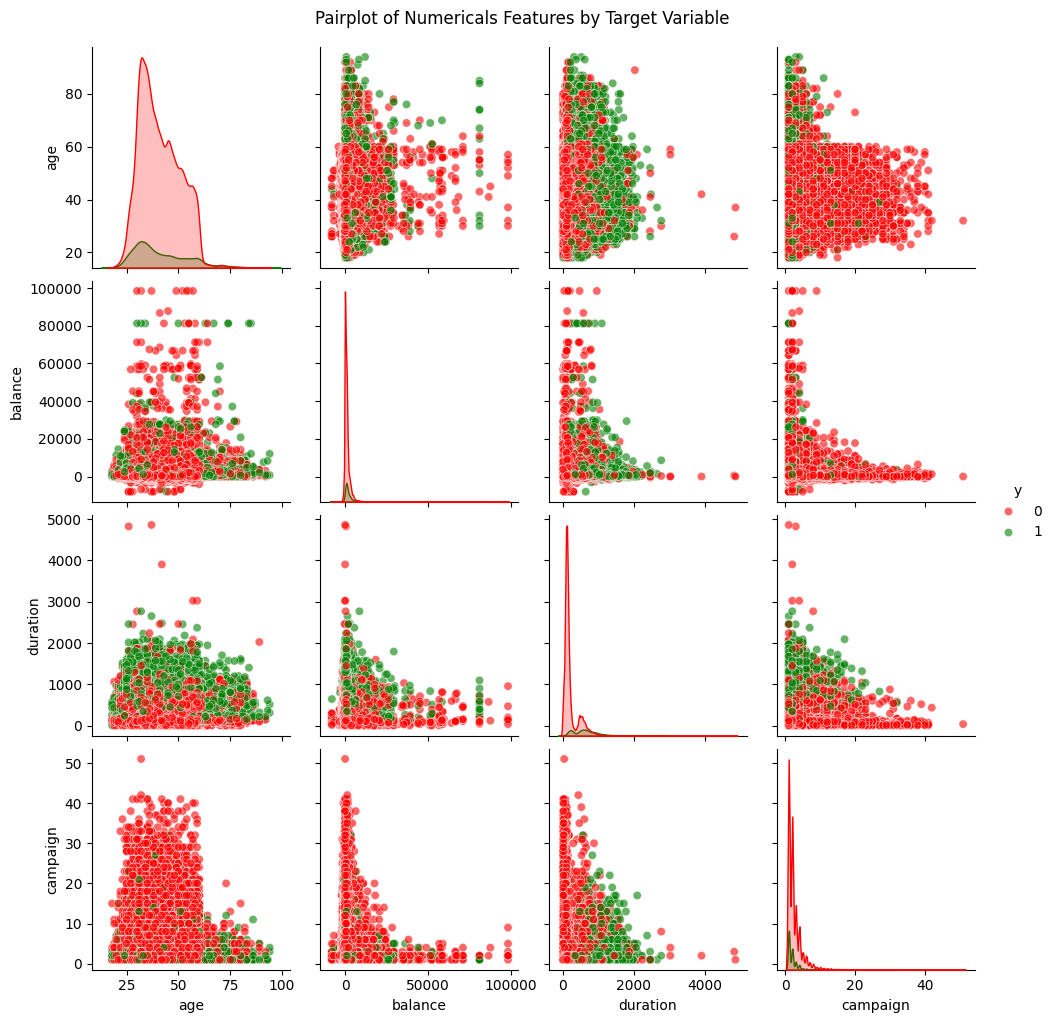

In [6]:
# Using 20% sample
sample_df = df_train.sample(frac=0.2, random_state=42)

sns.pairplot(sample_df,
             vars=['age','balance','duration', 'campaign'],
             hue='y',
             palette={0:'red', 1:'green'},
             plot_kws = {'alpha':0.6})

plt.suptitle("Pairplot of Numericals Features by Target Variable", y=1.02)
plt.show()

### 3. Categorical vs Target Variable 

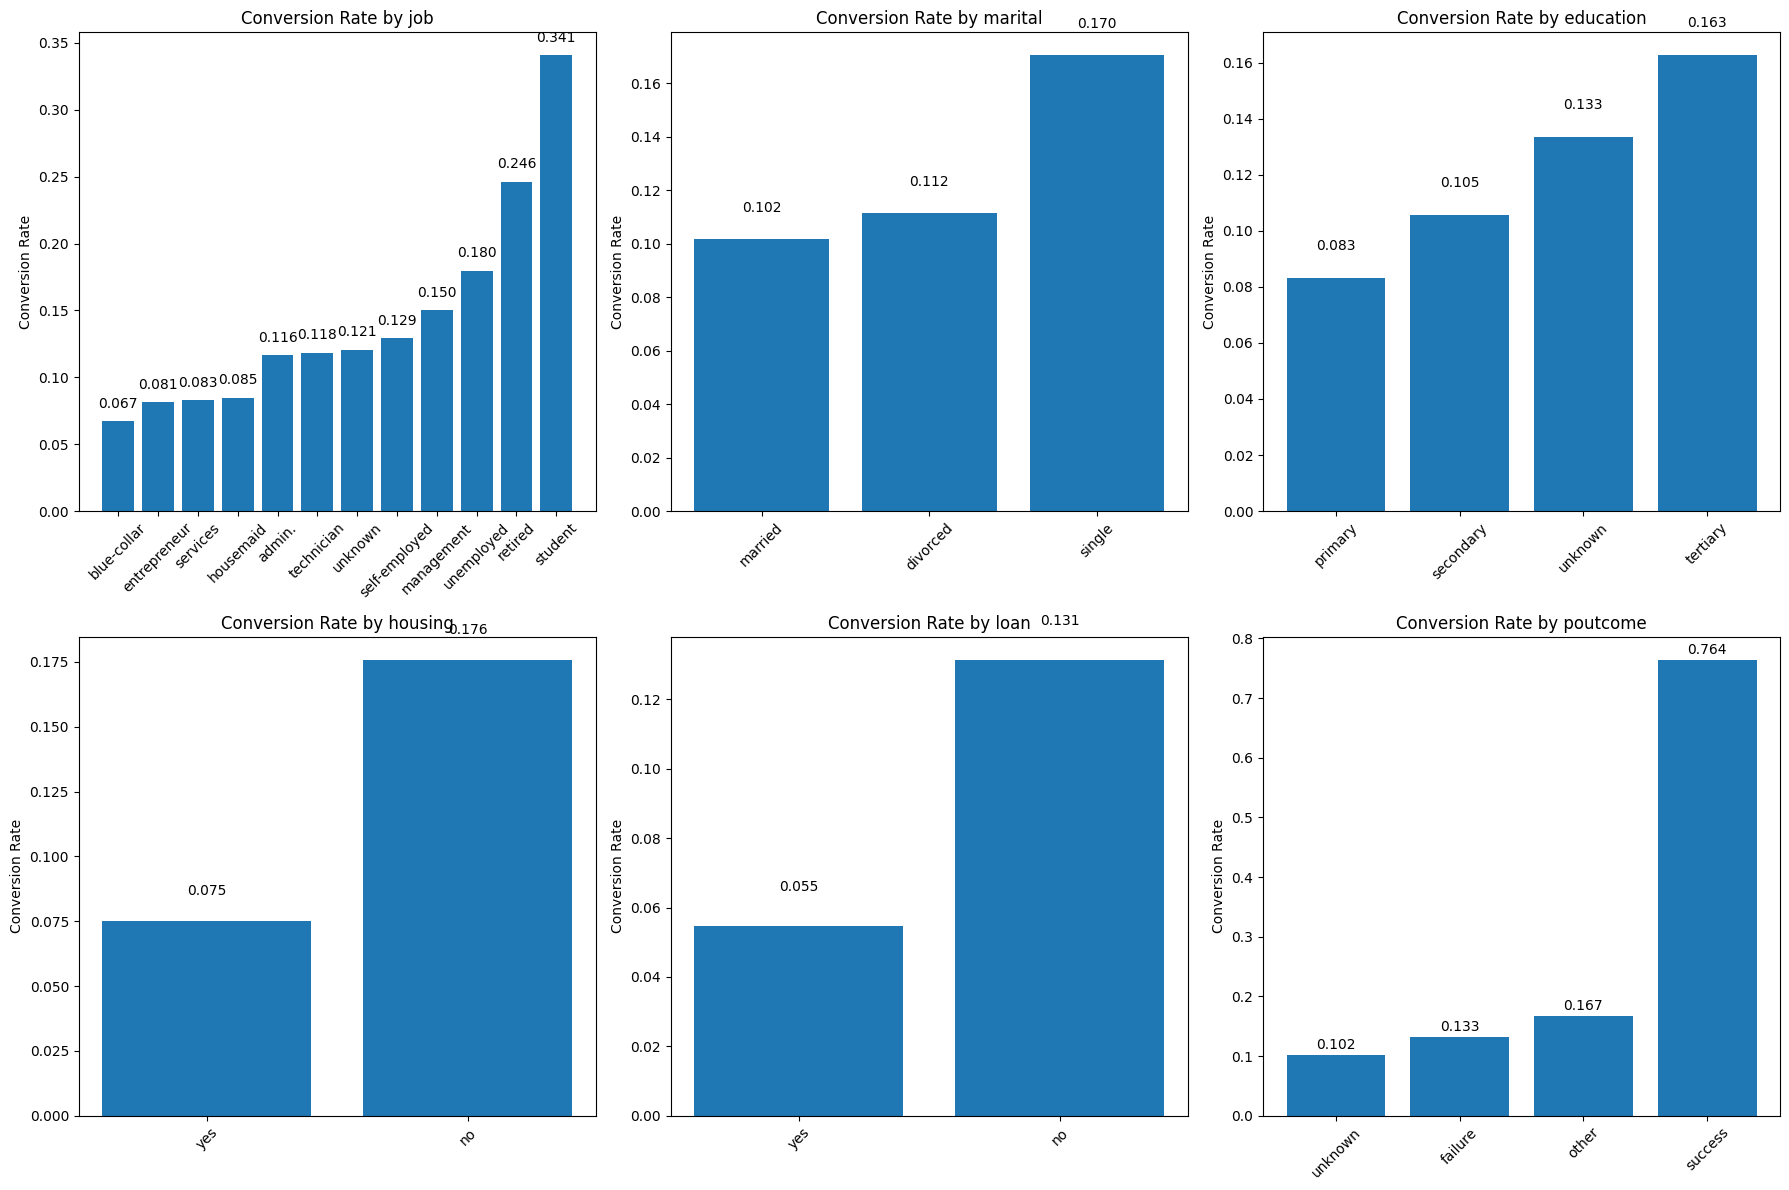

In [7]:
# Plot categorical features against target
categorical_features = ['job', 'marital', 'education', 'housing','loan','poutcome']

fig, axes = plt.subplots(2,3, figsize = (18,12))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
  conversion_rates = df_train.groupby(col)['y'].mean().sort_values()
  axes[i].bar(conversion_rates.index.astype(str), conversion_rates.values)

  axes[i].set_title(f'Conversion Rate by {col}')
  axes[i].set_ylabel('Conversion Rate')
  axes[i].tick_params(axis='x', rotation = 45)

  for j, v in enumerate(conversion_rates.values):
    axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show() 

### 4. Distribution Plots by Target

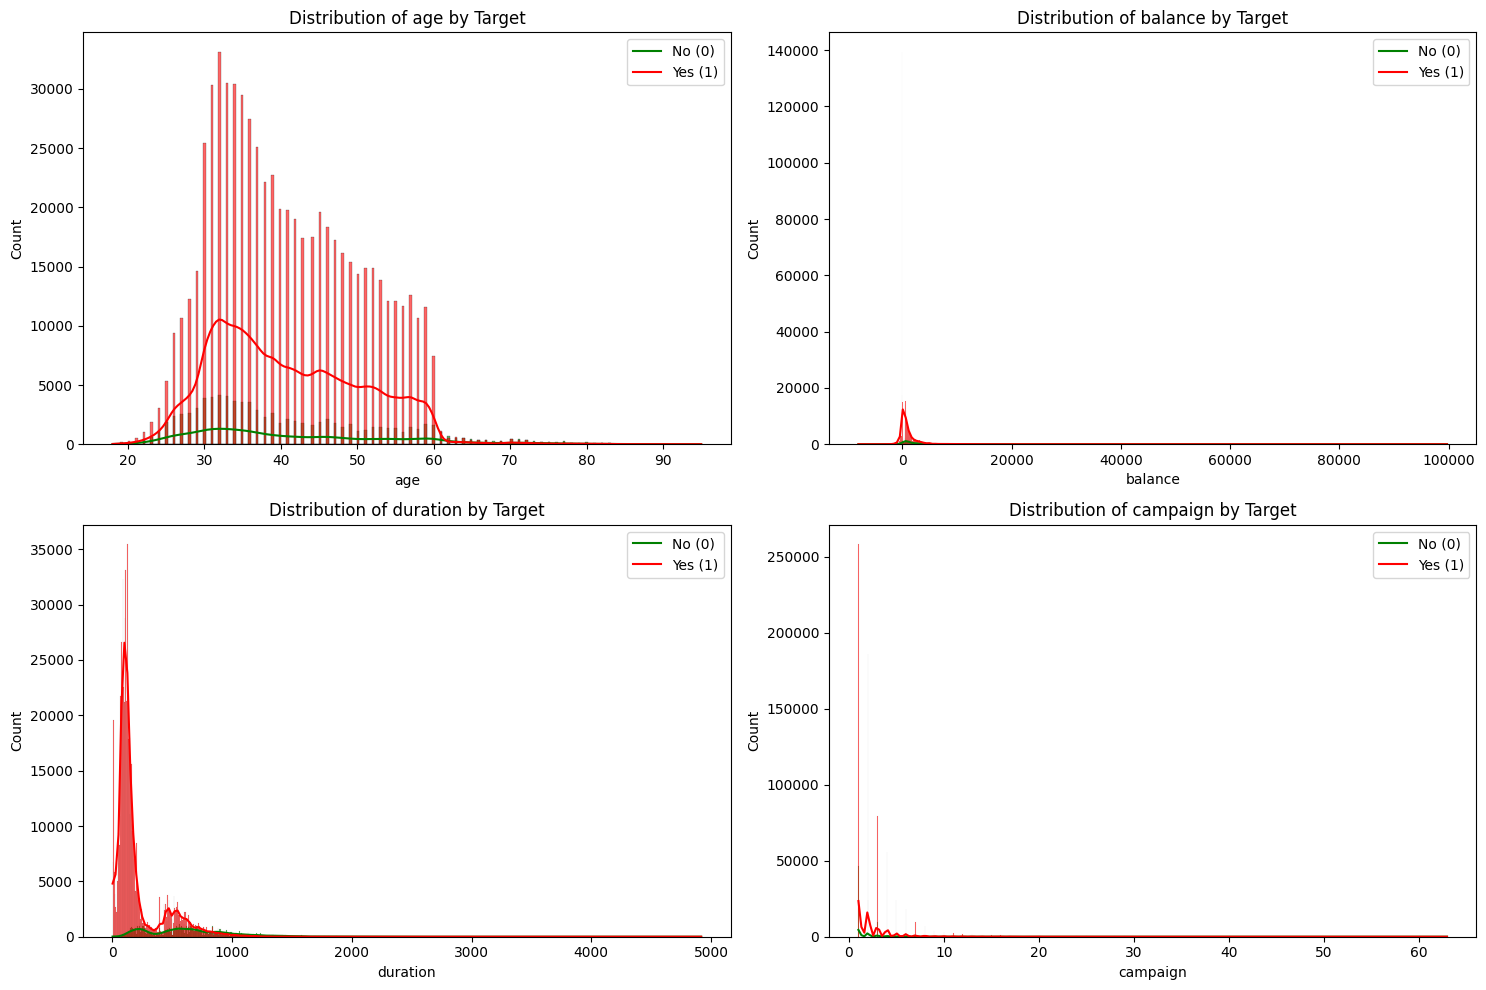

In [8]:
# Distribution of numerical features by target
numerical_features = ['age', 'balance', 'duration', 'campaign']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.histplot(data=df_train, x=col, hue='y', kde=True, 
                 palette={0: 'red', 1: 'green'}, 
                 alpha=0.6, ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Target')
    axes[i].legend(['No (0)', 'Yes (1)'])

plt.tight_layout()
plt.show()

### 5. Box plots - Numerical vs Categorical

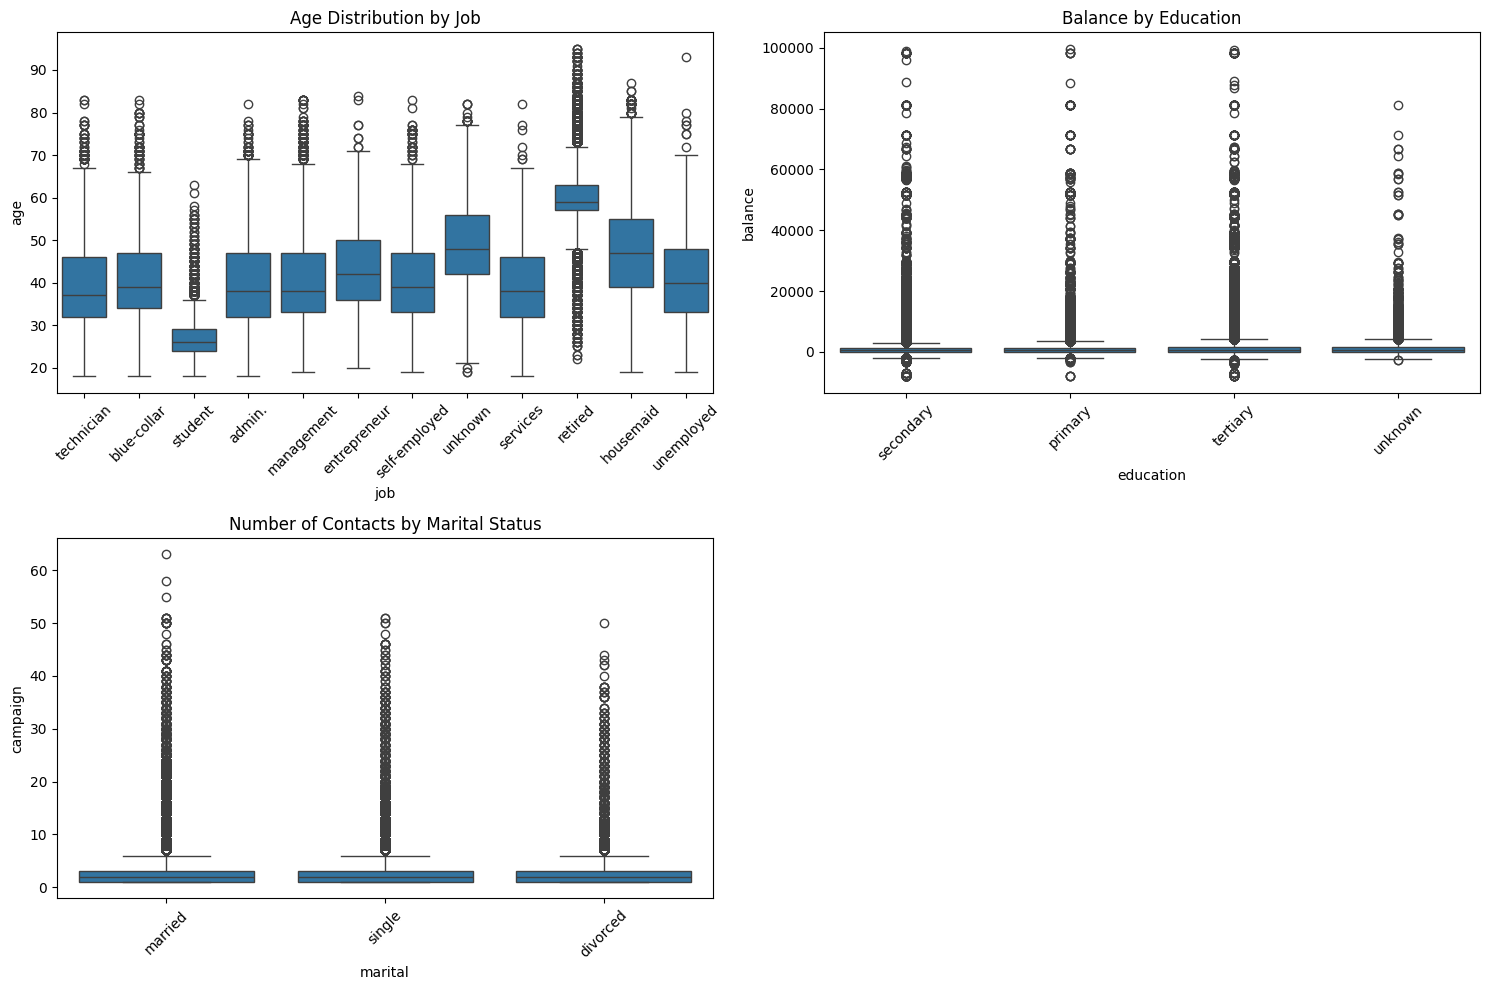

In [9]:
# Box plot for numerical features across categories
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# age by job categories
sns.boxplot(data=df_train, x='job', y='age', ax=axes[0, 0])
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].set_title("Age Distribution by Job")

# Balance by education 
sns.boxplot(data=df_train, x='education', y='balance', ax=axes[0, 1])
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_title("Balance by Education")  # Added title for consistency

# Duration by poutcome 
sns.boxplot(data=df_train, x='marital', y='campaign', ax=axes[1, 0])  # Changed to [1, 0]
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_title("Number of Contacts by Marital Status")

# Add a fourth plot or leave empty
axes[1, 1].set_visible(False)  # Hide the empty subplot

plt.tight_layout()  
plt.show()

### 6. Stacked Bar charts 

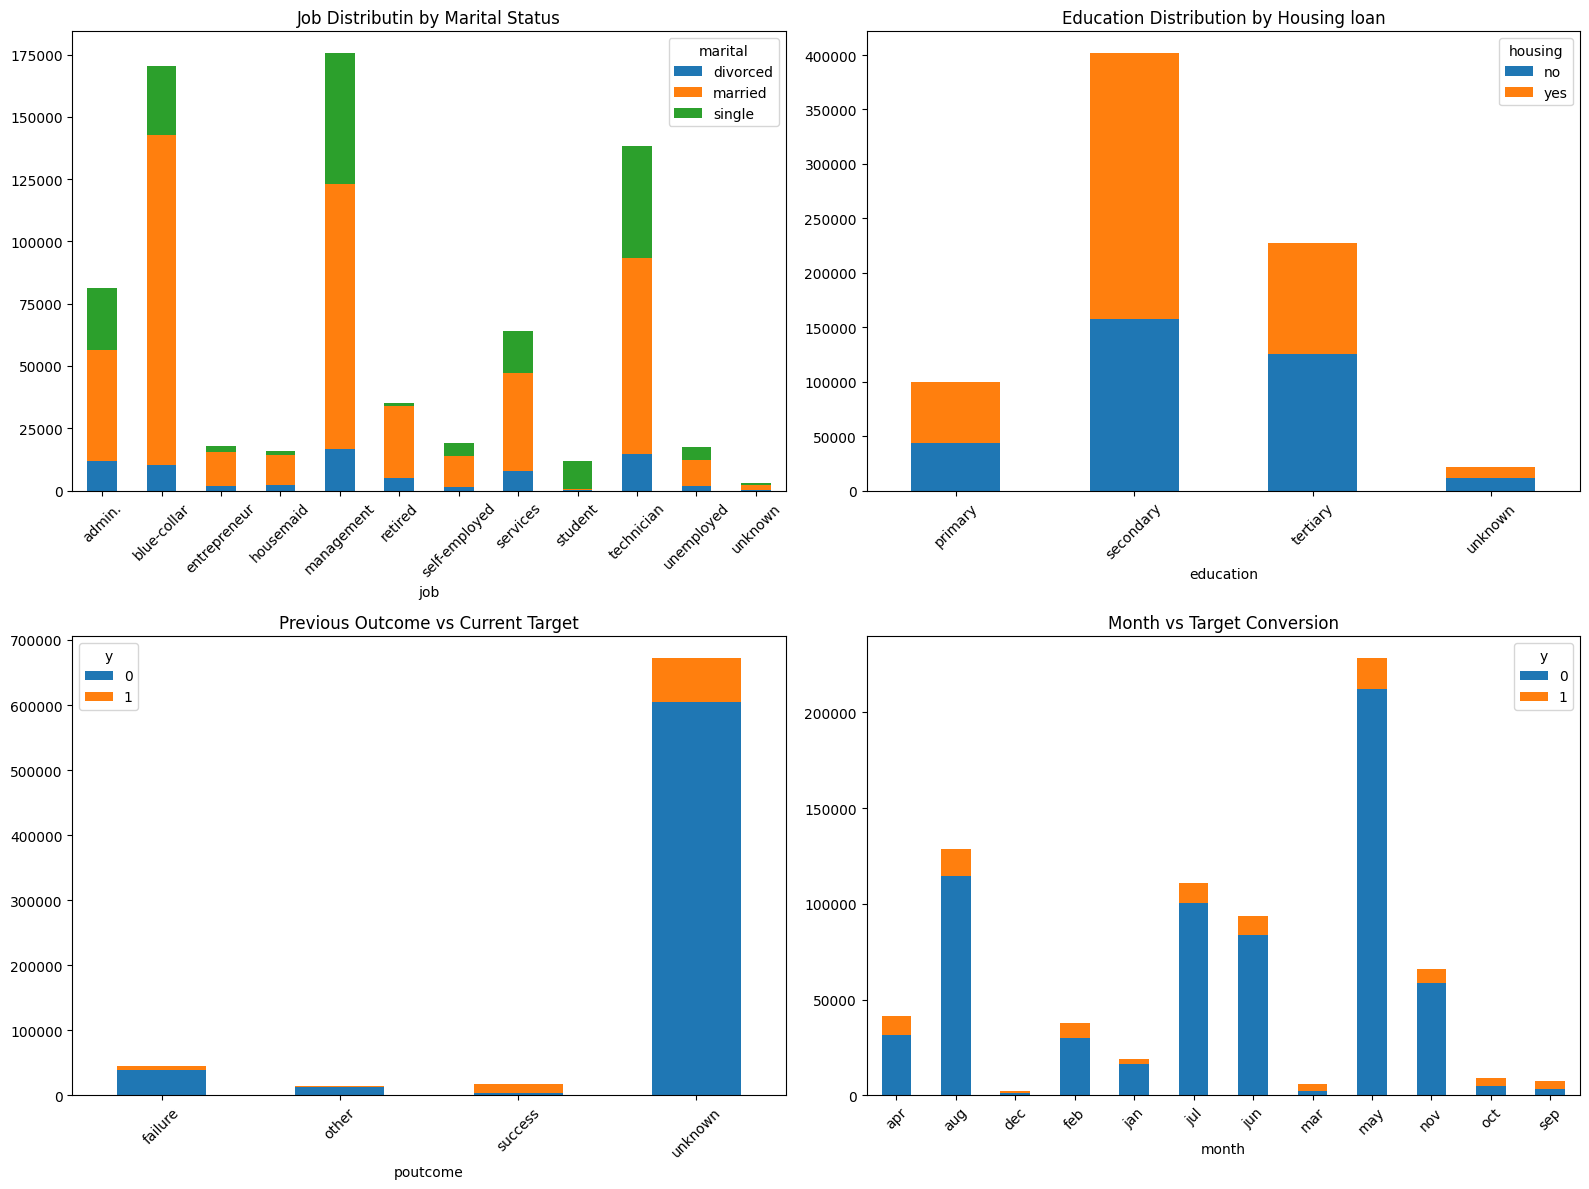

In [10]:
# Stacked bar charts for categorical relationship 
fig, axes = plt.subplots(2,2, figsize = (16,12))

# job vs marital status
job_marital = pd.crosstab(df_train['job'], df_train['marital'])
job_marital.plot(kind='bar', stacked=True, ax=axes[0,0])
axes[0,0].set_title("Job Distributin by Marital Status")
axes[0,0].tick_params(axis="x",rotation=45)

# Education vs Housing loan
edu_housing = pd.crosstab(df_train['education'], df_train['housing'])
edu_housing.plot(kind='bar', stacked=True, ax=axes[0,1])
axes[0,1].set_title('Education Distribution by Housing loan')
axes[0,1].tick_params(axis='x', rotation= 45)

# poutcome vs target 
poutcome_target = pd.crosstab(df_train['poutcome'], df_train['y'])
poutcome_target.plot(kind='bar', stacked=True, ax=axes[1,0])
axes[1,0].set_title("Previous Outcome vs Current Target")
axes[1,0].tick_params(axis='x', rotation = 45)

# month vs target 
month_tar = pd.crosstab(df_train['month'],df_train['y'])
month_tar.plot(kind='bar', stacked='True', ax= axes[1,1])
axes[1,1].set_title("Month vs Target Conversion")
axes[1,1].tick_params(axis='x', rotation = 45)

plt.tight_layout()
plt.show()

### 7. Violen Plots

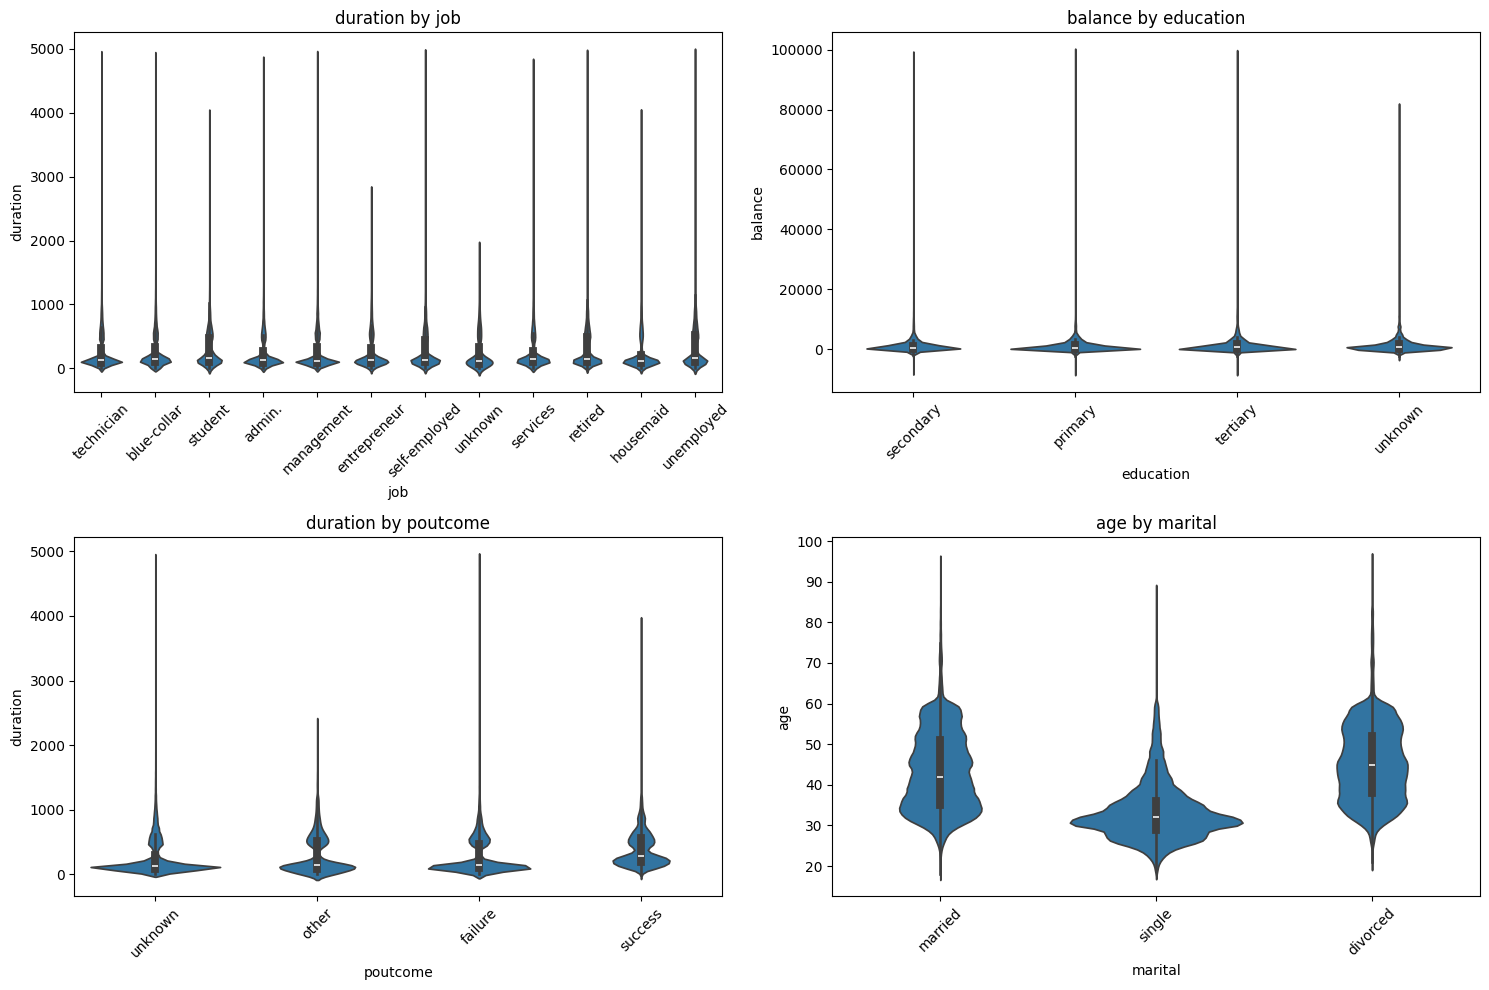

In [11]:
# Violin plots for detailed distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

features_to_plot = [
    ('job', 'duration'),
    ('education', 'balance'),
    ('poutcome', 'duration'),
    ('marital', 'age')
]

for i, (cat_col, num_col) in enumerate(features_to_plot):
    row, col = i // 2, i % 2
    sns.violinplot(data=df_train, x=cat_col, y=num_col, ax=axes[row, col])
    axes[row, col].tick_params(axis='x', rotation=45)
    axes[row, col].set_title(f'{num_col} by {cat_col}')

plt.tight_layout()
plt.show()

## EDA

In [13]:
# Encode target 
df_train['y'] = df_train['y'].map({'no':0, 'yes':1})

target = 'y'
features = [col for col in df_train.columns if col != target]

X = df_train[features]
y = df_train[target]
X_test = df_test[features]

In [16]:
# Encode categoricals: CatBoost can handle categorical directly, but LightGBM requires encoding. To keep things consistent, we'll LabelEncode all categorical 

cat_cols = X.select_dtypes(include="object").columns
for col in cat_cols:
  le = LabelEncoder()
  le.fit(list(X[col].astype(str))+ list(X_test[col].astype(str)))
  X.loc[:,col] = le.transform(X[col].astype(str))
  X_test.loc[:,col] = le.transform(X_test[col].astype(str))